#### Feedforward Neural Network Language Model using Skip-Gram Dense Embeddings

In [116]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import LSTM
from keras.layers import Bidirectional


import utils

In [138]:
# constants 
SENTENCE_BEGIN = "<s>"
SENTENCE_END = "</s>"
PADDING = '<pad>'

EMBEDDINGS_SIZE = 50
BATCH_SIZE = 128

GENRE = "Power-Pop" # change to build models for different genres 
MODEL_SAVE_PREFIX = "power_pop" # will be used to save and load models

In [139]:
# read in cleaned data
song_df = pd.read_csv('clean_data.csv')
print(song_df.shape)
song_df.head(5)

(171855, 5)


,artist,song_name,lyrics,language,genres
0,ivete sangalo,Careless Whisper,I feel so unsure\nAs I take your hand and lead...,en,"['Pop', ' Axé', ' Romântico']"
1,ivete sangalo,Could You Be Loved / Citação Musical do Rap: S...,"Don't let them fool, ya\nOr even try to school...",en,"['Pop', ' Axé', ' Romântico']"
2,ivete sangalo,Cruisin' (Part. Saulo),"Baby, let's cruise, away from here\nDon't be c...",en,"['Pop', ' Axé', ' Romântico']"
3,ivete sangalo,Easy,"Know it sounds funny\nBut, I just can't stand ...",en,"['Pop', ' Axé', ' Romântico']"
4,ivete sangalo,For Your Babies (The Voice cover),You've got that look again\nThe one I hoped I ...,en,"['Pop', ' Axé', ' Romântico']"


#### Prepare the Dense Embeddings for Words in the Lyrics of a Given Genre

In [140]:
# testing using the Power-Pop genre
lyrics = utils.get_lyrics_in_genre(song_df, GENRE, verbose=True)
# add a single sentence start and end token around each sequence 
tokens = [utils.tokenize_line(line, ngram=1) for line in lyrics] 
sequences = [' '.join(seq) for seq in tokens]
print('token examples:', '\n', sequences[0], '\n', sequences[1])

Selected 802 / 802 in the genre Power-Pop
Total sequences: 25559
token examples: 
 <s> la la la la la </s> 
 <s> la la na na na </s>


Mean Length: 9.088305489260144
Median Length: 9.0
Max Length: 13.0
Max Length: 68


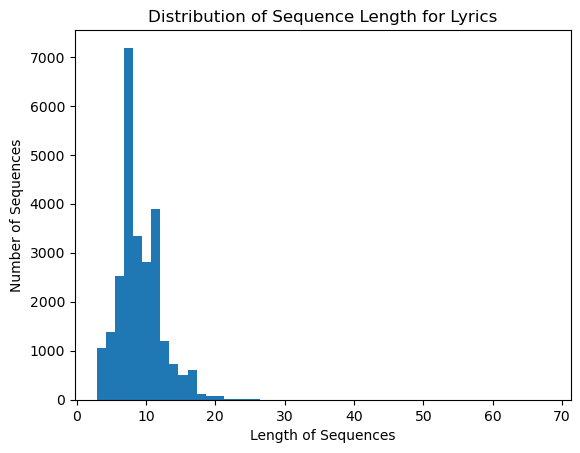

In [141]:
# plot lengths of sequences to determine an appropriate length to pad/truncate to
sequence_lengths = [len(seq) for seq in tokens]

print("Mean Length:", np.mean(sequence_lengths))
print("Median Length:", np.median(sequence_lengths))
print("Max Length:", np.percentile(sequence_lengths, 90))
print("Max Length:", np.max(sequence_lengths))

plt.hist(sequence_lengths, bins=50)
plt.xlabel("Length of Sequences")
plt.ylabel("Number of Sequences")
plt.title("Distribution of Sequence Length for Lyrics")
plt.show()

In [142]:
# Based on this data, pick a set sequence length that can capture most of the data without excessive padding
SEQUENCE_LENGTH = 12

# truncate sequences longer than the chosen length 
padded_sequences = []
for sequence in tokens:
    if len(sequence) < SEQUENCE_LENGTH:
        num_padding = SEQUENCE_LENGTH - len(sequence)
        padded_sequences.append(sequence + ([PADDING] * num_padding))
    else:
        padded_sequences.append(sequence[:SEQUENCE_LENGTH])

print('length-adjusted token examples:', '\n', padded_sequences[0], '\n', padded_sequences[1])

length-adjusted token examples: 
 ['<s>', 'la', 'la', 'la', 'la', 'la', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
 ['<s>', 'la', 'la', 'na', 'na', 'na', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [143]:
# NOTE: experimental 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(padded_sequences)
encoded_sequences = tokenizer.texts_to_sequences(padded_sequences)

print(tokenizer.word_index)
print("Vocab Size:", len(tokenizer.word_index))
print('encoded examples:', '\n', encoded_sequences[0], '\n', encoded_sequences[1])

{'<pad>': 1, '<s>': 2, '</s>': 3, 'i': 4, 'you': 5, ',': 6, 'the': 7, 'to': 8, 'it': 9, 'and': 10, 'a': 11, "n't": 12, "'s": 13, 'me': 14, '.': 15, 'do': 16, 'in': 17, 'my': 18, 'of': 19, 'on': 20, 'your': 21, 'that': 22, 'all': 23, 'know': 24, 'is': 25, "'m": 26, 'we': 27, 'be': 28, "'re": 29, 'for': 30, '(': 31, 'but': 32, 'so': 33, 'what': 34, 'just': 35, '?': 36, 'she': 37, 'got': 38, 'na': 39, 'up': 40, "'ll": 41, 'now': 42, 'no': 43, ')': 44, 'love': 45, 'like': 46, 'can': 47, 'oh': 48, "'": 49, 'when': 50, 'get': 51, 'with': 52, "'ve": 53, 'ca': 54, 'if': 55, 'one': 56, 'see': 57, 'time': 58, 'out': 59, 'go': 60, 'they': 61, 'never': 62, 'there': 63, 'yeah': 64, 'want': 65, 'down': 66, 'not': 67, 'are': 68, 'have': 69, 'this': 70, 'was': 71, 'will': 72, 'come': 73, 'at': 74, 'night': 75, 'say': 76, 'take': 77, 'gon': 78, 'he': 79, 'baby': 80, 'make': 81, 'world': 82, 'right': 83, 'her': 84, 'wan': 85, 'need': 86, 'away': 87, 'way': 88, 'could': 89, 'too': 90, 'let': 91, 'been': 

In [144]:
# NOTE: experimental 
# Based on this data, pick a set sequence length that can capture most of the data without excessive padding
SEQUENCE_LENGTH = 12

padded_encoded_sequences = keras.utils.pad_sequences(encoded_sequences, maxlen=SEQUENCE_LENGTH, padding='post', truncating='post')
print(padded_encoded_sequences.shape)
print('padded encoded examples:', '\n', padded_encoded_sequences[0], '\n', padded_encoded_sequences[1])


(25559, 12)
padded encoded examples: 
 [  2 124 124 124 124 124   3   1   1   1   1   1] 
 [  2 124 124  39  39  39   3   1   1   1   1   1]


In [145]:
# create word embeddings using skip gram algorithm
word_embeddings = Word2Vec(sentences=padded_sequences, vector_size=EMBEDDINGS_SIZE, window=5, sg=1, min_count=1)
print('Vocab size for word embeddings:', len(word_embeddings.wv))

Vocab size for word embeddings: 7220


#### Create Functions Needed to Train a Neural Network Language Model

In [160]:
# Function that gives mappings from words to their embeddings and  
# indexes from the tokenizers to their embeddings

def map_embeddings(embeddings: Word2Vec, tokenizer: Tokenizer) -> (dict, dict):
    ''' Creates mappings between different token representations 
    Parameters:
        embeddings: Word2Vec word embeddings for the data (maps tokens to embedding vectors)
        tokenizer: Tokenizer used to tokenize the data (needed to get the word to index mapping)
    Returns:
        (dict): mapping from word to its embedding vector
        (dict): mapping from index to its embedding vector
    '''
    # initialize dictionaries 
    token_to_embedding = {}
    index_to_embedding = {}

    # tokenizer maps tokens to unique indices 
    for token, index in tokenizer.word_index.items():
        embedding = embeddings[token]

        token_to_embedding[token] = embedding
        index_to_embedding[index] = embedding

    return (token_to_embedding, index_to_embedding)


token_to_embedding, index_to_embedding = map_embeddings(word_embeddings.wv, tokenizer)

padding_index = tokenizer.word_index.get(PADDING)
index_to_embedding[padding_index] = [0] * EMBEDDINGS_SIZE
token_to_embedding[PADDING] = [0] * EMBEDDINGS_SIZE

#### Create functions to generate new sequences 

In [147]:
def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 index_2_embedding: dict, 
                 seed: list):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        seed: [w1, w2, w(n-1)]
    Returns: an array of tokens 
    '''
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
    sentence_end_index = tokenizer.word_index.get(SENTENCE_END)

    # track the unique token indices for the sequence 
    sequence_indices = [tokenizer.word_index.get(tok) for tok in seed] 

    nn_input_length = len(seed)
    # until we get a SENTENCE_END token
    while sequence_indices[-1] != sentence_end_index:
        # get the latest n-1 token indices 
        input_sequence = sequence_indices[-1*nn_input_length:]

        # convert the input sequence to embeddings (concatenated together)
        input_embeddings = []
        for idx in input_sequence:
            input_embeddings.extend(index_2_embedding[idx])

        # convert to numpy array
        input_embeddings = np.array([input_embeddings])

        # get probability distribution on vocabulary for the next token in the sequence 
        prediction = model.predict(input_embeddings, verbose=False)

        next_tok_idx = np.random.choice(len(prediction[0]), p=prediction[0])

        # skip mid-sentence SENTENCE_BEGIN tokens
        if next_tok_idx == sentence_begin_index:
            continue

        sequence_indices.append(next_tok_idx)

    tokenizer_keys = list(tokenizer.word_index.keys())
    tokenizer_kv_pairs = list(tokenizer.word_index.values())
    sequence = [tokenizer_keys[tokenizer_kv_pairs.index(idx)] for idx in sequence_indices]
    return sequence

In [170]:
def generate_sequences(model: Sequential, 
                      tokenizer: Tokenizer, 
                      index_2_embedding: dict, 
                      num_seq: int,
                      by_char: bool):
    '''
    Generates a given number of sequences using the given neural network language model.
    Will begin the sequence generation with n-1 SENTENCE_BEGIN tokens.
    Returned sequences will have the BEGIN and END tokens removed
    For character models, _ will be replaced with spaces  

    Parameters:
        model: neural network language model
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        num_seq: the number of sequences to generate 
        by_char: True if a character model, False if a word model is used 
        n: the size of the ngram used to train the neural network model

    Returns: 
        a list of strings, where each string is a generated sequence with <s> or </s> tokens removed 
    '''
    seed =  ([PADDING] * (SEQUENCE_LENGTH - 1)) + [SENTENCE_BEGIN]
    
    # ([PADDING] * (SEQUENCE_LENGTH - 1)) +  nltk.word_tokenize("i want to dance all night and all day to the sound of this music")
    sequences = []
    for _ in range(num_seq):
        seq = generate_seq(model, tokenizer, index_2_embedding, seed)

        if by_char:
            seq = ''.join(seq)
            seq = seq.replace('_', ' ')
        else:
            seq = ' '.join(seq)

        # remove special tokens
        #seq = seq.replace(SENTENCE_BEGIN, '')
        #seq = seq.replace(SENTENCE_END, '')
        #seq = seq.replace(PADDING, '')

        sequences.append(seq.strip())
        
    return sequences

#### Feedforward Neural Net Language Model

#### RNN with LSTMS 

In [175]:
def data_generator(data: list, num_sequences_per_batch: int, index_2_embedding: dict) -> (np.array, np.array):
    '''
    Returns data generator to be used by the neural network

    Yields batches of embeddings and labels to go with them.
    Use one hot vectors to encode the labels 

    Args:
    X (2-D numpy array): sequences of the first n-1 token indices from training data ngrams [[x1, x2, ... , x(n-1)], ...]
    y (1-D numpy array): list of all the labels aka the nth token index from training data ngrams [y1, y2, ...]
    num_sequences_per_batch (int): batch size yielded on each iteration of the generator 
    index_2_embedding (dict): mapping between unique token indices and dense word embeddings 

    Returns:
    X_batch_embeddings (3-D numpy array): sequences of embeddings in the form [[x1_word_embedding] [x2_word_embedding], ... [x(n-1)_word_embedding], ...]
    y_batch (2-D numpy array): a list of one hot vectors encoding labels in the form [y1_one_hot_vector, y2_one_hot_vector, ...]
    '''
    # iterate over data in batches - stored in the form of unique token indices 
    i = 0
    while True:
        # get samples that we'd like to train on for this batch 
        data_batch = data[i:i+num_sequences_per_batch]
        i += num_sequences_per_batch

        # get embeddings for all token indices 
        data_embeddings = []
        for sequence in data_batch:
            data_embeddings.append([index_2_embedding[token_idx] for token_idx in sequence])

        # split into X and Y -- shifted sequence so that for each timestep, Y is the token that follows X 
        X = [sequence[:-1] for sequence in data_batch]
        Y = [sequence[1:] for sequence in data_batch]

        # get embeddings for X data 
        X_embeddings = []
        for X_sequence in X:
            X_sequence_embeddings = [index_2_embedding[token_idx] for token_idx in X_sequence]
            X_embeddings.append(X_sequence_embeddings)

        # represent labels as one hot vectors 
        # resulting shape is (batch_size, |V|) (vocab size is the length of the index -> embedding dictionary)
        Y_one_hot_vectors = []
        for Y_sequence in Y:
            Y_one_hot = to_categorical(Y_sequence, num_classes=len(index_2_embedding))
            Y_one_hot_vectors.append(Y_one_hot)

        # yield statement instead of return for generator 
        yield(np.array(X_embeddings), np.array(Y_one_hot_vectors))


# demo the data generator

demo_data_generator = data_generator(encoded_sequences, BATCH_SIZE, index_to_embedding)
demo_sample = next(demo_data_generator)
print("X batch shape:", demo_sample[0].shape)
print("y batch shape:", demo_sample[1].shape)

X batch shape: (128, 11, 50)
y batch shape: (128, 11, 7220)


In [168]:
def generate_seq(model: Sequential, 
                 tokenizer: Tokenizer, 
                 index_2_embedding: dict, 
                 seed: list):
    '''
    Parameters:
        model: your neural network
        tokenizer: the keras preprocessing tokenizer
        index_2_embedding: mapping from token index -> word2vec embeddings 
        seed: [w1, w2, w(n-1)]
    Returns: an array of tokens 
    '''
    padding_index = tokenizer.word_index.get(PADDING)
    sentence_begin_index = tokenizer.word_index.get(SENTENCE_BEGIN)
    sentence_end_index = tokenizer.word_index.get(SENTENCE_END)

    # TODO remove 
    tokenizer_keys = list(tokenizer.word_index.keys())
    tokenizer_kv_pairs = list(tokenizer.word_index.values())

    # track the unique token indices for the sequence 
    sequence_indices = [tokenizer.word_index.get(tok) for tok in seed] 


    #print(seed)
    #print(sequence_indices)

    nn_input_length = len(seed)
    # until we get a SENTENCE_END token
    while sequence_indices[-1] != sentence_end_index:
        # get the latest n-1 token indices 
        input_sequence = sequence_indices[-1*nn_input_length:]

        # convert the input sequence to embeddings (concatenated together)
        input_embeddings = []
        for idx in input_sequence:
            input_embeddings.append(index_2_embedding[idx])

        # convert to numpy array
        input_embeddings = np.array([input_embeddings])

        # get probability distribution on vocabulary for the next token in the sequence 
        predictions = model.predict(input_embeddings, verbose=False)[0]

        prediction = predictions[-1]

        next_tok_idx = np.random.choice(len(prediction), p=prediction)

        # skip mid-sentence SENTENCE_BEGIN tokens
        #if next_tok_idx == sentence_begin_index or next_tok_idx == padding_index:
            #continue

        #print(tokenizer_keys[tokenizer_kv_pairs.index(next_tok_idx)])
        sequence_indices.append(next_tok_idx)

    tokenizer_keys = list(tokenizer.word_index.keys())
    tokenizer_kv_pairs = list(tokenizer.word_index.values())
    sequence = [tokenizer_keys[tokenizer_kv_pairs.index(idx)] for idx in sequence_indices]
    return sequence

#### RNN with LSTMs

In [165]:
def lstm_rnn(data: np.array, 
             num_sequences_per_batch: int, 
             index_2_embedding: dict, 
             num_epochs: int=1, 
             embedding_size: int=EMBEDDINGS_SIZE, 
             verbose: bool=False):
    """
    Creates and trains a simple recurrent neural network using given training data.
    Args:
        X_train (list of list): featurized training data
        y_train (list): training data labels
        num_sequences_per_batch (int): batch size for training data 
        index_2_embedding (dict): mapping from token index -> word2vec embeddings 
        num_epochs (int): number of training epochs
        n (int): n-gram size used in the training data
        embedding_size (int): size of the dense word embeddings used for X_train
        verbose (bool): if epoch training progress should be printed
    Returns:
        a trained Neural Network model
    """
    # define model parameters
    hidden_units = 128
    hidden_input_dim = (data.shape[1] - 1,1)   
    output_dim = len(index_2_embedding)             # vocab size 

    # instantiate model
    model = Sequential()

    # mask the padding token 
    model.add(Masking(mask_value=0.0))

    # hidden layer
    model.add(Bidirectional(LSTM(hidden_units, 
                                 input_shape=hidden_input_dim,
                                 return_sequences=True)))

    # output layer
    model.add(Dense(units=output_dim, activation='softmax'))

    # configure the learning process
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    
    #model.summary()
    
    # total number of batches per epoch 
    steps_per_epoch = len(data)//num_sequences_per_batch

    for _ in range(num_epochs):

        # create a new data generator for us to iterate through
        train_generator = data_generator(data, num_sequences_per_batch, index_2_embedding)
        # train model 
        model.fit(x=train_generator, steps_per_epoch=steps_per_epoch, verbose=True)

    return model

In [176]:
lstm_model = lstm_rnn(np.array(encoded_sequences), BATCH_SIZE, index_to_embedding, num_epochs=5, verbose=True)

199/199 [==============================] - 41s 205ms/step - loss: 1.7784 - accuracy: 0.7210


In [178]:
lstm_seq = generate_sequences(lstm_model, tokenizer, index_to_embedding, num_seq=10, by_char=False)
print("Sequence generated with LSTM model:\n")
for seq in lstm_seq:
    print(seq)

Sequence generated with LSTM model:

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> you came her phone </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> fills less react surrenders loving worth beer ? </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> dependant tomorrow everything nervousness stadium why pretty baby </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> good 're guess burninâ€™ eye high </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> why </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> ape january harming abstract </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> little bit telephone must looks final to low </s>
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <s> keeping frat green today </s>
<pad> <pad> <pad> 